In [1]:
#!pip install pandas seaborn pytypes 
# to launch: https://mybinder.org/v2/gh/pestrela/music_scripts/master


# https://jupyter.org/try
# https://docs.python.org/3.4/library/xml.etree.elementtree.html
import xml.etree.ElementTree as ET
import os, sys
import pandas as pd
import glob, os
import numpy as np

from pathlib import Path,  PureWindowsPath

import pandas as pd
import seaborn as sns

import numpy             as np
import matplotlib.pyplot as plt
#import matplotlib.pylab  as pylab
#import matplotlib.image  as mpimg
#import seaborn           as sns

from IPython.display import display as ipython_display

#from pytypes import typechecked
import json
import collections

    
#####
##### library functions follow
#####

def dict_remove_key(d, key, default=None):
    """
    removes a key from dict __WITH__ side effects
    Returns the found value if it was there (default=None). It also modifies the original dict.
    """
    return d.pop(key, default)


def swap(a,b):
    return (b,a)




def internal_seaborn_facetgrid_myfunc(y, kind, **kwargs):
    data = kwargs.pop('data')
    #x = dict_remove_key(kwargs, 'x')
    ax = plt.gca()
    serie = data[y]

    if len(serie) == 0:
        print("WARNING: no data for CDF seaborn plot")
        print(y,kind)
      

    if kind == "cdf":
        serie_sorted = np.sort(serie)
        p = 1.0 * np.arange(len(serie)) / (len(serie) - 1)
        plt.plot(serie_sorted, p, **kwargs)
    elif kind == "dist":
        sns.distplot(serie, norm_hist=True, hist=False, kde=True)
    else:
        raise  ValueError('seaborn_FacetGridplot: unknown Kind')

def my_raise(x):
    raise x
        

def print_nonl(*args, **kwargs):
    """
    print(value, ..., sep=' ', end='\n', file=sys.stdout, flush=False)

    Prints the values to a stream, or to sys.stdout by default.
    Optional keyword arguments:
      file:  a file-like object (stream); defaults to the current sys.stdout.
      sep:   string inserted between values, default a space.
      end:   string appended after the last value, default a newline.
      flush: whether to forcibly flush the stream.
    """
    print(*args, end="", ** kwargs)
        
        

def df_count_NA(df):
    return df.isnull().sum().sum()


def df_has_NAs(df):
    return df_count_NA(df) > 0


def seaborn_FacetGridplot(data, y, kind="cdf"                 # args required 
                          , replace_NAs=True
                          , replace_NA_value=0
                          , title="", figsize=None            # args SETTED to final grid
                          , xlim=None, ylim=None              # args SETTED to all subplots
                          , size=3, aspect=2, col_wrap=2      # args PASSED to aLL subplots
                          , sort_lines=True
                          , **kwargs):
    
    """
    main wrapper to FacetGrid.
    Please see options in https://seaborn.pydata.org/generated/seaborn.FacetGrid.html#seaborn.FacetGrid
    
    """


    #### NA problems:
    if df_has_NAs(data):
        # todo: find exactly which columns we need, and drop the other ones.
        print_nonl("Warning: NAs found in given data (maybe in some unrelated columns). ")
        if replace_NAs:
            print("These will all be replaced by %s!" % (replace_NA_value))
            data = data.fillna(replace_NA_value, inplace=False) 
        else:
            print("NO ACTION TAKEN. Expect problems!")
            
            
    ####
    # adds defaults to kwargs
    #kwargs['col_wrap'] = col_wrap
    kwargs['size']   = size
    kwargs['aspect'] = aspect
    
    
    ### support breakdown lists by making the powerset on the fly
    ### https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
    if False:
        # DISABLED CODE
        
        x              = dict_remove_key(kwargs, 'x')
        data, x        = df_melt_breakdown(data, x)
        kwargs['x']    = x

        hue            = dict_remove_key(kwargs, 'hue')
        data, hue      = df_melt_breakdown(data, hue)
        kwargs['hue']  = hue

        col            = dict_remove_key(kwargs, 'col')
        data, col      = df_melt_breakdown(data, col)
        kwargs['col']  = col

        row            = dict_remove_key(kwargs, 'row')
        data, row      = df_melt_breakdown(data, row)
        kwargs['row']  = row


    
    extra_title           = dict_remove_key(kwargs, 'extra_title')
    if extra_title:
        title = "%s\n%s" % (title, extra_title)
        


    ### force hues to be sorted
    # todo: do cols and rows as well
    x          = dict_remove_key(kwargs, 'x')
    hue        = dict_remove_key(kwargs, 'hue')
    hue_order  = dict_remove_key(kwargs, 'hue_order')

    # all the above are optional. Provide defaults in this case
    if (hue is None):
        hue = x
    if (x is None):
        x = hue
    if (hue is not None) and (hue_order is None):
        #hue_order = np_unique_unsorted(data[hue], format_output="series")
        pass
        
    kwargs['hue']       = hue
    kwargs['hue_order'] = hue_order
    #############
    
    
    if (kind == "count"):
        # https://seaborn.pydata.org/generated/seaborn.catplot.html
        
        assert(y is None)

        y          = dict_remove_key(kwargs, 'y')

        hue        = dict_remove_key(kwargs, 'hue')
        hue_order  = dict_remove_key(kwargs, 'hue_order')
    
        if x is None:
          #my_raise("countplot: need to specify either 'x' or 'hue'")
          x = hue

        g = sns.catplot(data=data, y=x, x=None, kind="count", **kwargs)
        
    elif (kind == "line") or (kind == "point"):
        hue_order = dict_remove_key(kwargs, 'hue_order')
        
        assert(x is not None)  # <<<<< IMPROVE THIS
        
        if (kind == "line"):
          sub_plt = plt.plot
          if sort_lines:
            data = data.sort_values(x)
        elif (kind == "point"):
          sub_plt = plt.scatter
        
        #x          = dict_remove_key(kwargs, 'x')
          
        g = sns.FacetGrid(data, **kwargs)
        g.map(sub_plt, x, y).add_legend()
      
    elif (kind == "box") or (kind=="bar"):
        # from https://seaborn.pydata.org/generated/seaborn.boxplot.html
        # "Using factorplot() is safer than using FacetGrid directly, as it ensures synchronization of variable order across facets"
        
        x_order  = dict_remove_key(kwargs, 'hue_order')   ## TODO!
        if x is None:
          x = dict_remove_key(kwargs, 'hue')
        
        g = sns.factorplot(x=x, y=y, data=data, kind=kind, **kwargs)


        
    else:
        # swap xlim - even if they dont exist!
        #kwargs = dict_swap_keys(kwargs, 'xlim', 'ylim')
        
        xlim, ylim = swap(xlim, ylim)
        
        g = sns.FacetGrid(data=data, **kwargs)
        g = g.map_dataframe(internal_seaborn_facetgrid_myfunc, y, kind)

    #sns.factorplot(data=df, x="extra", y='sepal_length', col="extra", sharey=True, kind='point', size=6, aspect=1.5).set_xticklabels(rotation=90).fig.suptitle("dede", y=1.02)  
    
    g.add_legend()
    set_kwargs = dict(xlim=xlim, ylim=ylim) #, figsize=figsize)
    g.set(**set_kwargs).fig.suptitle(title, y=1.05)
        
    return g
  
    
    


def seaborn_cdfplot(data, y, **kwargs):
    """
    Wrapper to CDF calculated by hand.
    Please see seaborn_FacetGridplot() for parameter list
    """
    return seaborn_FacetGridplot(data, y, kind="cdf", **kwargs)


def seaborn_countplot(data, *, y=None, count_ylim=None, **kwargs):
    """
    Wrapper to catplot(kind="count")
    Note that "y" is always ignored, to keep compatibility with the CDFPLOT. Use "hue" or "x" instead!
    Please see seaborn_FacetGridplot() for parameter list
    """
    
    if not (y is None):
      print("Warning: specified 'y' parameter '%s'. CountPlot() always ignores this " % (y))

    return seaborn_FacetGridplot(data, y=None, kind="count", **kwargs)
    #ret = sns.catplot(data=data, y=None, x=x, hue=None, kind="count", ylim=count_ylim, **kwargs)


def seaborn_cdfplot_with_count(data, *, y=None, **kwargs):
    """
    shows two plots simultaneously (CDF + count)
    Please see seaborn_FacetGridplot() for parameter list
    """
    
    hue            = dict_remove_key(kwargs, 'hue')
    kwargs['hue']  = hue
    
    extra_title = df_count_groupby_desc(data, hue)
    
    seaborn_cdfplot(data=data, y=y, extra_title=extra_title, **kwargs)
    #seaborn_countplot(data=data, y=y, **kwargs)
    #df_display_count_groupby(data, hue)

    
#####
##### NEW library fuctions follow here
#####    


def dict_merge(*args, warn_collisions=False):
    # https://stackoverflow.com/questions/3494906/how-do-i-merge-a-list-of-dicts-into-a-single-dict
    
    ret = {}
    for d in args:
        ret.update(d)
        
    return ret


def df_count_groupby(df, col=None):
    """
    counts how many entries generated by a groupby. 
    break col may be optional, then it counts all entries
    
    output: 
     - dataframe
     - display dataframe
     - one-liner
    """
    
    if col and (not col in df.columns):
        col = None
        
    if col is None:
        df = pd.DataFrame([len(df) ], columns=["count"])
        df.index = ['all']
    else:
        df = df.groupby(col).count().iloc[:,0:1]
        df.columns = ['count']
        
    return df

    
def df_count_groupby_display(df, col=None):
    """
    as above, but displays the result
    """
    df = df_count_groupby(df, col)
    ipython_display(df)
    return None


def df_count_groupby_desc(df, col=None, multi_line=False):
    """
    as above, but output is a oneliner
    """
    
    #df = df_count_groupby(df, col)

    df = df_count_groupby(df, col)
    st = str(df).strip().replace("\n", ";  ")
    st = " ".join(st.split())

    return "COUNT: %s" % (st)



def df_diff_columns_1e3(*args, multiplier=1000, **kwargs):
    return df_diff_columns(*args, multiplier=multiplier, **kwargs)
    

    
def df_diff_columns(df, col1, col2, new_name=None, *, multiplier=1, frac_digits=0):
    if new_name is None:
        col1_1 = col1.split("_")[0]
        col1_2 = col1.split("_")[1]
        col2_1 = col2.split("_")[0]
        col2_2 = col2.split("_")[1]
        
        if col1_1 == col2_1:
            new_name = "%s_vs_%s_%s" % (col1_2, col)
            # FIXME: finish this

    df[col1] = df[col1].astype(float)
    df[col2] = df[col2].astype(float)
            
                
    df[new_name] = (df[col1] - df[col2])*multiplier
    df[new_name] = df[new_name].round(frac_digits)
    
    if frac_digits == 0:
        df[new_name] = df[new_name].astype(int)
        
    return df


def df_preview_intermediate_df(df, groupby=None, n_head=2, n_tail=None, debug=True):
    if not debug:
        return
    
    if n_tail is None:
        n_tail = n_head
    
    print("*************")
    tmp_df = pd.concat([df.head(n_head), df.tail(n_tail)])
    
    ipython_display(tmp_df)
    
    df_display_count_groupby(df, groupby)


def df_query_contains(df, col, value):
    return df[df[col].str.contains(value)]
    

def df_preview_query_contains(df, col, value):
    try:
        df = df_query_contains(df, col, value)
    except:
        print("Warning: %s %s not found" % (col, value))
        df = df.head(1)
        
    ipython_display(df)
    
    
def df_read_csv_string(st, **kwargs):
    from io import StringIO
    return pd.read_csv(StringIO(st), **kwargs)


def df_preview_debug(df, in_function_return=False):
    """
    drop this function to preview the intermediate dataframes.
    Can also be used as a decorator to see returned functions
    
    flavors are:
     a) just see the general structure of the dataframes (head+tail)
     b) instead, track a SPECIFC row over and over  (good to check input files)
     
    options are:
     - see nothing
     - see returned functions dfs
     - see intermediate steps as well
    """
    
    global options
    
    #master_disable_debug = True
    master_disable_debug = False
    
    
    track_one_row_value = options['track_one_row_value']
    show_intermediate_dfs = options['show_intermediate_dfs']
    
    if master_disable_debug:
        return None
    
    if show_intermediate_dfs == 0:
        return None
    elif show_intermediate_dfs == 1:
        if not in_function_return:
            return None
    elif show_intermediate_dfs == 2:
        pass
    else:
        raise 

    ## show an intermediate dataframe
    if track_one_row_value:
        df_preview_query_contains(df, "stem", options['track_one_row_value'])
    else:
        df_preview_intermediate_df(df)

    return None


def decorator_df_preview_debug(df):
    #print("dede")
    return df_preview_debug(df, in_function_return=True)
        

def df_assert_no_NAs(df):
    """
    duplicate columns cause havok in pandas.

    note: not to be confused with duplicate rows!
    """
    if df_has_NAs(df):
        raise ValueError("Dataframe has NAs")
    return None
        
    

#####
##### Main program functions starts here
#####



def type_encoder(x):
    x = x.lower()
    if "lavf" in x:
        return "LAVF"
    if "lavc" in x:
        return "LAVC"
    if "av" in x:
        return "AV"
    elif "lame" in x:
        return "LAME"
    elif "unk" in x:
        return "UNK_ENC"
    else:
        return "OTHER_ENC"

    
def read_ffprobe(ffprobe_file = "ffprobe.csv"):
    # to generate this csv from Alex's tool:
    #   ln -sf ../../collection\ files/1\ -\ TK\ collection.nml collection.nml
    #   ln -sf ../../collection\ files/4\ -\ rekordbox\ -\ small\ collection.xml rekordbox.xml
    #    #cat ffprobe.edn  | egrep  "/mnt/|:encoder" |  awk '{if(index($1, "mnt")){ print FILE "  " ENC;  FILE=$0; ENC="UNK"} else { ENC=$3 }}' > ffprobe.csv
    
    # new version:
    #   find . -iname "*.mp3" | tr '\n' '\0' | xargs -0 -n1 -- ffprobe 2>&1 | cat - > step1.txt
    #   cat step1.txt | egrep -i "encode|Input.*from" | egrep -B1 -i "encoder.* : Lav" > step2.txt
    #   cat step2.txt | egrep "^Input" -A1 | egrep -v "^--"  | paste - - |  cut -b21- | sed 's/:.*:/,/' > ffprobe.csv
        
    a = pd.read_csv(ffprobe_file, names=['file',"encoder"], quotechar="'")
    a['file'] = a['file'].str.replace('"','').str.strip()
    a['stem'] = a['file'].apply(lambda x: Path(x).stem)

    a['encoder'] = a['encoder'].str.replace('"','').str.replace('}','').str.strip()
    
    a['encoder_simple'] = a['encoder'].apply(type_encoder)
    
    a = a[['stem','encoder', 'encoder_simple']]
    return a


    
def display_versions(versions):
    display(df_read_csv_string(versions, sep='\s+').set_index("Program"))
        

def df_convert_to_stem(df, col="file", new_col="stem"):
    df[new_col] = df[col].apply(lambda x: Path(x).stem)
    return df


def do_cdf_plot(df, *, y=None, hue=None, do_abs=None, lim=None, **kwargs):
    global options
    
    sns.set()
    df = df.copy()
    
    if lim is None:
        lim = options['cdf_lim']

    if do_abs is None:
        do_abs=options['cdf_do_abs']
    
    if do_abs:
        df[y] = df[y].abs()
        ylim=(0, lim)
        #ylim=(-lim, lim)
    else:
        ylim=(-lim, lim)
    
    #hue="tag"
    #hue = "encoder"

    seaborn_cdfplot_with_count(df, y=y, hue=hue, height=4, aspect=3, ylim=ylim, **kwargs)

    
def do_cdf_plot_breakdown_tag(df, y_list=None, hue_list=None, *, do_agg=False, title=None, **kwargs):
    """
    show CDF plot of:
     - hue=tag (iterated)
     - hue=None (merging everything)
    """
    
    # always add non-breakdown first
    if hue_list is None:
        hue_list = [None]
    else:
        if do_agg:
            hue_list = [None] + hue_list
        else:
            hue_list = hue_list
        
    if y_list is None:
        raise
        
    if title is None:
        raise
        
    ### do it
    for y in y_list:
        for hue in hue_list:
            #if hue is not None:
            #    df_display_count_groupby(df, hue)
                
            y_title = '%s     (y="%s")' % (title, y)
            do_cdf_plot(df, y=y, hue=hue, title=y_title, **kwargs)    
            
            
            


def json_flatten_dict(d: dict, parent_key='', sep='_') -> dict:
    # https://stackoverflow.com/questions/32557920/what-are-type-hints-in-python-3-5
    # https://stackoverflow.com/questions/6027558/flatten-nested-dictionaries-compressing-keys
    
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        
        if isinstance(v, list):
            for i, z in enumerate(v):
                items.extend(json_flatten_dict(z, new_key + sep + str(i), sep=sep).items())
                
        elif isinstance(v, dict) or isinstance(v, collections.MutableMapping):
            items.extend(json_flatten_dict(v, new_key, sep=sep).items())
            
        else:
            items.append((new_key, v))
            
    return dict(items)

def json_flatten_list(l : list, parent_key='', sep='_') -> list:
    ret = [ json_flatten_dict(i) for i in l]
    return ret


def json_flatten(v):
    if isinstance(v, list):
        return json_flatten_list(v)
    elif isinstance(v, dict):
        return json_flatten_dict(v)
    else:
        raise ValueError("json_flatten: unsuported type: %s" % (type(v)))


        
            

In [2]:
#####
##### Main program statements starts here
#####

# to generate TK XML file:   ./dj-data-converter-win\ 0.2.1.exe 1\ -\ TK\ collection.nml

versions="""
 Program Version
 TraktorPro 3.1.1_8
 Rekordbox  5.4.1
 FFMPEG_BATCH 1.6.5
 ffmpeg 4.1.1
 ffprobe 4.1.1
 MediaInfoLib v18.12
 mpg123  1.25.10
 Fraunhofer_iis 1.4
"""


def tag_vbr(x):
    if x in [320,192, 128]:
        return "CBR"
    else:
        return "VBR"



def bpm_period(bpm):
    return (60.0 / bpm )

def find_min_beat(bpm, cue):
    period = bpm_period(bpm)
    
    beats = int(cue / period)
    ret = cue - beats * period
    return ret

#def  find_offset(bpm1, cue1, bpm2, cue2):
#    return find_min_beat(bpm1, cue1) - find_min_beat(bpm2, cue2)



def read_rb_file(file, source):
    global options
    
    file = options['data_folder'] + "/" + file

    
    root = ET.parse(file).getroot()
    collection=root.find('COLLECTION')

    limit=None
    #limit=20
    i=0
    debug=False

    rets = []
    for entry in collection:
        location = entry.get('Location')
        location = location.replace("%20", " ")

        #if not "ALEX" in location:
        #    continue
        
        #print(options['exclude_one_row'], location)
        
        if options['exclude_one_row'] in location:
            print("WARNING: dropping file on %s: %s" % (source, stem))
            continue
            
        location = PureWindowsPath(location)
        stem = location.stem
        parent = str(location.parent)
        
        tempo_entry = entry.find('TEMPO')
        try:
            inizio = float(tempo_entry.get("Inizio"))
        except:
            print("WARNING: dropping file on (%s): %s" % (source, stem))
            continue
            
        bpm = float(tempo_entry.get("Bpm"))

        
        if "/mp3/" in parent:
            compression = "mp3"
        elif "/wav/" in parent:
            compression = "wav"
        else:
            compression = "unk"

        if "2 bad shift" in parent:
            tag = "bad_shift"
        elif "1 good shift" in parent:
            tag = "good_shift"
        else:
            print("dede")
            raise Exception("bad TAG on music file %s" % (parent))

            
        min_beat = find_min_beat(bpm, inizio)
                
        ret = [stem, min_beat, inizio, bpm, compression, source, tag]
        
        rets.append(ret)

        #break
        
        i=i+1
        if limit and (i > limit):
            break
            
    df = pd.DataFrame(rets, columns=['stem', 'min_beat', 'inizio', 'bpm', 'compression', 'source', 'tag'])
    #df = rets
    
    df['inizio'] = df['inizio'].astype(float)
    df['bpm'] = df['bpm'].astype(float)
    df['min_beat'] = df['min_beat'].astype(float)
    print("\n\nDone reading %s collection. Total entries was %d" % ( source, len(df)))
    
    
    df_preview_debug(df)

    
    # reduce columns for joining
    df = df[['stem', 'tag', 'min_beat']]
    #df_preview_debug(df)
    return df




def pivot_collection_files(input_df1, input_df2):
    #pivot_df = pd.pivot_table(input_df, index=['stem','tag'], columns=['source','compression'], values=['inizio'],
    #               fill_value=0) #, aggfunc=[np.sum])
    #pivot_df.columns=[RB_mp3', 'TK_mp3' ]
    #pivot_df = pivot_df.reset_index()

    pivot_df = pd.merge(input_df1, input_df2, on=['stem', 'tag'])
    pivot_df.columns=['stem', 'tag', 'RB_mp3', 'TK_mp3' ]
    
    df_preview_debug(pivot_df)
    return pivot_df
    
    


def step1_read_dj_collections(input_df1, input_df2):
    """
    input:
      2x DJ collections files in RB_XML format
      This collection has both MP3 and WAV files; and folders containing the tag "good"/"bad"
    
    output is a dataframe with these fields:
      stem: index to join later
      tag: manually seen shift / no shift
      RB_vs_TK_adj: offset that was automatically measured (with WAV correction)
      
    terminology:
      RB_vs_TK_mp3 = "X+Y"
      RB_vs_TK_wav = "Y"
      RB_vs_TK_adj = "X"
    """
    global options
    
    
    
    if options['dump_versions']:
        display_versions(options['versions'])
    
    print("\n\nDoing step1")
   
    pivot_df = pivot_collection_files(input_df1, input_df2)
    return pivot_df



def step2_massage_dj_collections(merge_df):

    merge_df = df_diff_columns_1e3(merge_df, 'RB_mp3', 'TK_mp3', 'RB_vs_TK_mp3')
    merge_df['RB_vs_TK'] = merge_df['RB_vs_TK_mp3']

    #df_preview_debug(merge_df)

    value_cols=['RB_vs_TK']
    id_cols = ['stem', 'tag']
    merge_df= merge_df[id_cols + value_cols]
    collection_df = merge_df
    
    df_preview_debug(collection_df, True)
    do_cdf_plot_breakdown_tag(collection_df, ['RB_vs_TK'], ["tag"],  title='Traktor vs RekordBox INIZIOS (reduced)')
    return collection_df


def df_remove_outliers(df, col, oper, value, do_abs=True):
    """
    filter impossible values. These are either too low or too high.
    this is very ususaly explained by manual errors, decoding errors, etc
    """
    st = "%s %s %s" % (col, oper, value)
    return df.query(st)
        

def df_remove_too_small_values(df, col, value, do_abs=True):
    return df_remove_outliers(df, col, ">", value, do_abs=do_abs)
    
def df_remove_too_big_values(df, col, value, do_abs=True):
    return df_remove_outliers(df, col, "<", value, do_abs=do_abs)
    
    
def step3_read_csv_files(csv_file1, csv_file2):
    """
    input:
      - CSV file with encoder guess information
      - CSV file with decoded WAV number of samples (for several parameters)
    
    output is a dataframe with these fields:
      stem: index to join later
      
      encoder_*: tags of the several encoder guess programs
      
      fhg_vs_of1: default fhg vs fhg -of1
      fhg_vs_mpg: default fhg vs default mpg
      fhg_vs_mpg_nogapless: default fhg vs mpg --nogapless
    """
    global options
    
    print("Step3")
    
    csv_file1 = options['data_folder'] + "/" + csv_file1
    csv_file2 = options['data_folder'] + "/" + csv_file2
    
    csv_df1 = pd.read_csv(csv_file1, sep="|")
    csv_df2 = pd.read_csv(csv_file2, sep="|")

    csv_df1 = df_convert_to_stem(csv_df1)
    csv_df2 = df_convert_to_stem(csv_df2)

        
    df_preview_debug(csv_df1)
    
    
    csv_df = pd.merge(csv_df1, csv_df2, on='stem')

    
    csv_df = csv_df.rename(index=str, columns={"ffprobe": "encoder_ffprobe", "mp3guessenc": "encoder_mp3guessenc", "mediainfo":"encoder_mediainfo"})

    encoders_list = ["encoder_ffprobe","encoder_mp3guessenc", "encoder_mediainfo"]

    #csv_df['encoder'] = csv_df['encoder_ffprobe']
    #csv_df['encoder'] = csv_df['encoder_mediainfo']


    df_preview_debug(csv_df)
    
    
    csv_df = df_remove_too_small_values(csv_df, 'mpg_default', 100000)  # 100 seconds
    csv_df = df_remove_too_small_values(csv_df, 'mpg_nogapless', 100000)  # 100 seconds
        
    csv_df = df_diff_columns(csv_df, 'fhg_default', 'fhg_of1',       'fhg_vs_of1')
    csv_df = df_diff_columns(csv_df, 'fhg_default', 'mpg_default',   'fhg_vs_mpg')
    csv_df = df_diff_columns(csv_df, 'fhg_default', 'mpg_nogapless', 'fhg_vs_mpg_nogapless')

    csv_columns=['stem'] + encoders_list + ['fhg_vs_of1', 'fhg_vs_mpg', 'fhg_vs_mpg_nogapless']
    info_df = csv_df[csv_columns]

    #info_df = info_df.query('abs(fhg_vs_mpg) < 1000 ')  # remove impossible shifts
    df_preview_debug(info_df, True)   ## todo: make this a decorator
    return info_df


def read_ffprobe_json(json_file):
    # https://stackoverflow.com/questions/42023222/python-program-which-reads-and-extracts-specific-information-from-json-file-gene

    with open(json_file)as json_fd:
        json_data = json.load(json_fd)
        json_fd.close()
        print("read_json: read %d entries from %s" % (len(json_data), json_file))

    ret=[]
    for entry in json_data:
        #print(entry)
        try:
            stream = entry['streams'][0]
            basics = entry['format']
        except:
            continue

        e = dict_merge(stream, basics)
        e = json_flatten_dict(e)
        ret.append(e)

    df = pd.DataFrame(ret)
    
    df['stem'] = df['filename'].apply(lambda x: Path(x).stem)
    df['bitrate'] = (df['bit_rate'].astype(float) / 1e3).round(1).astype(int)
    
    df['vbr'] = df['bitrate'].apply(tag_vbr)
    df['start_time'] = (df['start_time'].astype(float) * 1e3)
    
    fields = ['stem', 'bitrate', 'vbr', 'start_time', 'start_pts', 'codec_time_base', 'duration', 'duration_ts', 'sample_rate',
        'time_base', 'sample_fmt']
    df = df[fields]
    
    
    df_assert_no_NAs(df)
    
    df_preview_debug(df, True)
    return df

options = {
    'show_intermediate_dfs': 1,      # 0: Nothing; 1: major step only ; 2: all
    'track_one_row': True,
    #'track_one_row': False,
    #'track_one_row_value':"Imagineer",
    #'track_one_row_value':"ALEX VARGAS",
    #'track_one_row_value':"New York City",
    #'track_one_row_value':'Clean Bandit',
    #'track_one_row_value': 'Wherever You Are', 
    #'track_one_row_value':'Trust In The Wind', 
    #'track_one_row_value':'POBSKY', 
    #'track_one_row_value':'New York City', 
    #'track_one_row_value':'DEEP CARE',
    #'track_one_row_value':'ICONA POP',
    'track_one_row_value':'SHOGUN',
    
    'exclude_one_row': 'Wherever You Are',   #this was for manual beatgrod errors
    
    'show_versions': False,

    'dump_versions':False,
    'versions':versions,

    'cdf_lim':200,
    'cdf_do_abs':False,
    'data_folder':"../data",
    
}



Done reading TK collection. Total entries was 111


Done reading RB collection. Total entries was 112


Doing step1


,stem,tag,RB_vs_TK
15,03 - SHOGUN - Space Odyssey - Original Mix,good_shift,0


/srv/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Step3


,stem,encoder_ffprobe,encoder_mp3guessenc,encoder_mediainfo,fhg_vs_of1,fhg_vs_mpg,fhg_vs_mpg_nogapless
13,03 - SHOGUN - Space Odyssey - Original Mix,UNK,UNK,UNK,548153,0,0


Step4


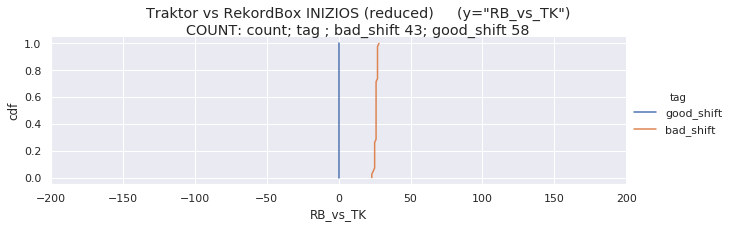

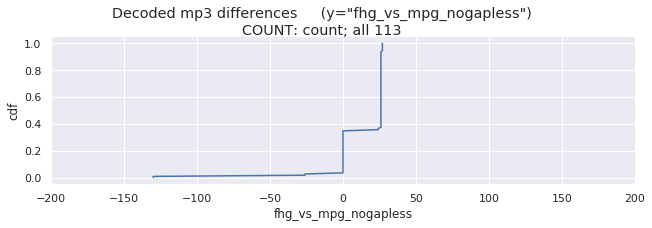

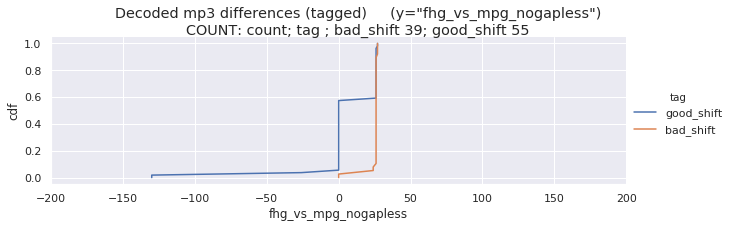

In [3]:

if True:
    file_tk="2 - TK - only small tagged dataset.xml"
    #file_rb="4 - RB - export of files just imported - small.xml"
    file_rb="6 - RB - export of corrected files - small.xml"
    
    input_df1 = read_rb_file(file_tk, "TK")
    input_df2 = read_rb_file(file_rb, "RB")
 
    input_df = step1_read_dj_collections(input_df1, input_df2)
    collection_df = step2_massage_dj_collections(input_df)
    

mp3_encoder_file="mp3_encoder.csv"
mp3_offset_file="mp3_offset.csv"
info_df = step3_read_csv_files(mp3_encoder_file, mp3_offset_file)
do_cdf_plot_breakdown_tag(info_df, ['fhg_vs_mpg_nogapless'], None, title='Decoded mp3 differences')

print("Step4")
merge_df = pd.merge(collection_df, info_df, on='stem')
df_preview_debug(merge_df)
do_cdf_plot_breakdown_tag(merge_df, [ 'fhg_vs_mpg_nogapless'], ['tag'], title='Decoded mp3 differences (tagged)')


Step5


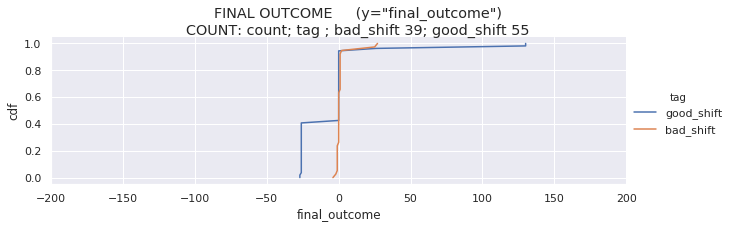

In [4]:

print("Step5")
merge_df['RB+TK__vs__FHG+MPGNGL'] = merge_df['RB_vs_TK'] - merge_df['fhg_vs_mpg_nogapless']
merge_df['final_outcome'] = merge_df['RB+TK__vs__FHG+MPGNGL']


simple_df = merge_df[['stem', 'tag', 'encoder_ffprobe', 'encoder_mp3guessenc', 'encoder_mediainfo', "final_outcome" ]]
df_preview_debug(simple_df)
do_cdf_plot_breakdown_tag(simple_df, ["final_outcome"], ["tag"],  title='FINAL OUTCOME')

#print("list of problematic good files:")
#df_remove_too_big_values(simple_df, "final", -4)

read_json: read 116 entries from ../data/mp3_ffprobe.json


/srv/conda/lib/python3.7/site-packages/ipykernel_launcher.py:599: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


,stem,bitrate,vbr,start_time,start_pts,codec_time_base,duration,duration_ts,sample_rate,time_base,sample_fmt
13,03 - SHOGUN - Space Odyssey - Original Mix,320,CBR,0.0,0,1/44100,548.153475,7735541839,44100,1/14112000,s16p


/srv/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


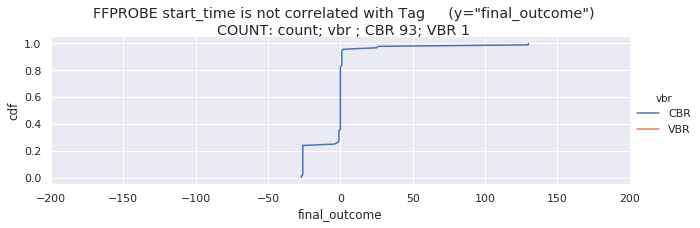

In [5]:
json_file = options['data_folder'] + "/" + "mp3_ffprobe.json"
ffprobe_df = read_ffprobe_json(json_file)
merge_df = pd.merge(simple_df, ffprobe_df, on=['stem'])

df = merge_df
do_cdf_plot_breakdown_tag(df, ["final_outcome"], ['vbr'], title="FFPROBE start_time is not correlated with Tag")
